In [1]:
import numpy as np
import pandas as pd
import matplotlib

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")



NumPy version: 1.23.5
Pandas version: 1.5.3
Matplotlib version: 3.7.0


In [62]:
from utils.readfile import*
from utils.barrel_data import*
from utils.doublet import*
from utils.triplet import*
from utils.plotting_utils import*
from utils.track_reconstruction_metric_triplet_level  import*
from utils.track_reconstruction_metric_hit_level  import*
from importlib import reload
import yaml
import json
from tqdm import tqdm
import pickle
from utils.cellular_automata import*
from utils.triplet_fit import*
class generated_tracks:
    pass

pd.set_option('display.max_columns', None) 

with open('files/pdgids.pkl','rb') as f:
    pdg_dict = pickle.load(f)
with open("config.yaml", "r") as f:

    # Load and parse the YAML file
    config = yaml.safe_load(f)
barrel_data = get_barrel_data(config)
config['sigma_cut'] = 3
layer_files = ['z0','dtheta','dkappa']
get_layer_wise_data(layer_files,config)
def fname(sigma_cut,eno):


    stage_dir = f'/mnt/data1/gupta/ca/{sigma_cut}' +'sigma/final_config/'

    triplet_arr_fname = stage_dir+f'triplets/triplet_arr{eno}.pkl'
    triplet_df_fname = stage_dir+f'triplets/triplet_df{eno}.pkl'
    ca_fname = stage_dir+f'ca_class/chi2_7_eno_{eno}.pkl'
    # triplet_fname = stage_dir+f'{track_segments}_eventno_'+str(eno)+'_signal_'+str(signal)+'_z0_'+str(z0)+'_pt_'+str(pt)+'.pkl'
    return triplet_arr_fname,triplet_df_fname,ca_fname


In [63]:
config['chi_square_cut'] = 7

In [65]:
# # chi2_triplet_truth_fname = 'chi2_triplet_truth.pkl'
# # chi2_triplet_false_fname = 'chi2_triplet_false.pkl'

# with open(chi2_triplet_truth_fname,'rb') as f:
#     chi2_triplet_truth = pickle.load(f)
# with open(chi2_triplet_false_fname,'rb') as f:
#     chi2_triplet_false = pickle.load(f)
# # 

# plt.hist(chi2_triplet_truth,bins=100,range = (0,10),density = True)
# plt.hist(chi2_triplet_false,bins=100,range = (0,10),density = True)
# plt.yscale('log')
# plt.show()


In [67]:

def filter_triplets(eno):
    arr_fname  = f'generated_tracks/triplets/chi2_7_triplet_arr{eno}.pkl'
    df_fname  = f'generated_tracks/triplets/chi2_7_triplet_df{eno}.pkl'
    return arr_fname,df_fname
    


for eno in tqdm(range(90)):
        
    hdf,pdf = read_files(eno)
    hits_df = load_barrel_df(hdf)
    signal_df = get_signal(hdf,pdf,config)




    triplet_arr_fname,triplet_df_fname,ca_fname = fname(config['sigma_cut_doublets'],eno)



    with open(triplet_arr_fname,'rb') as f:
        triplet_arr = pickle.load(f)
    with open(triplet_df_fname,'rb') as f:
        triplet_df = pickle.load(f)



    filtered_triplet_arr,filtered_triplet_df = triplet_array_after_chi2_cut(triplet_arr,triplet_df,config)

    arr_fname,df_fname = filter_triplets(eno)
    with open(arr_fname,'wb') as f:
        pickle.dump(filtered_triplet_arr,f)
    with open(df_fname,'wb') as f:
        pickle.dump(filtered_triplet_df,f)



100%|██████████| 90/90 [26:54<00:00, 17.94s/it]


In [54]:
with open(ca_fname,'rb') as f:
    ca = pickle.load(f)

pt_truth = []
pt_false = []

for i in range(len(ca.label)):
    if(ca.label[i]):
        pt_truth.append(ca.pt[i])
    else:
        pt_false.append(ca.pt[i])


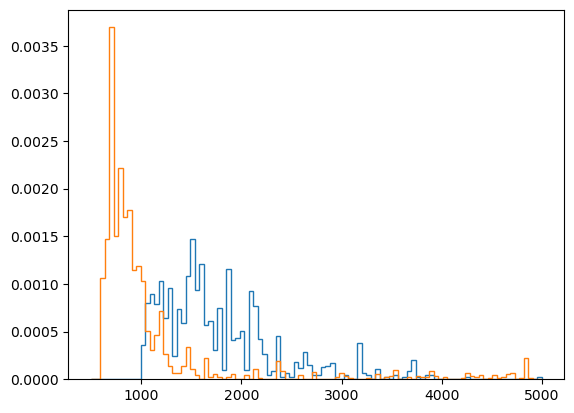

In [58]:
plt.hist(pt_truth,bins=100,range = (500,5000),density = True,histtype='step')
plt.hist(pt_false,bins=100,range = (500,5000),density = True,histtype='step')
plt.show()


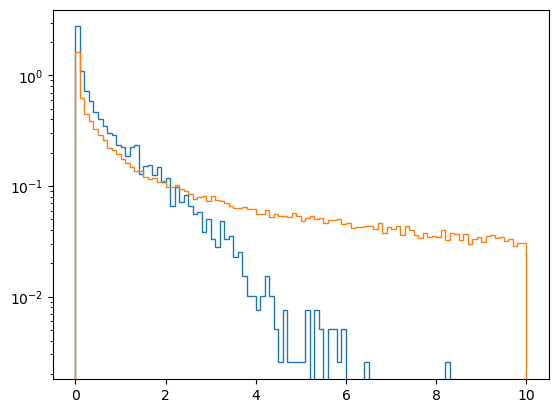

In [5]:
plt.hist(chi2_truth,bins=100,range = (0,10),density = True,histtype='step')
plt.hist(chi2_false,bins=100,range = (0,10),density = True,histtype='step')
plt.yscale('log')
plt.show()

In [49]:
a = [1,2,3]
for i in range(10):
    if i in a:
        print(a[i])



2
3


IndexError: list index out of range

In [59]:
triplet_arr_chi2,triplet_df_chi2 = triplet_array_after_chi2_cut(triplet_arr,triplet_df,config)

In [61]:
len(triplet_df_chi2)

41582

In [11]:
calculate_triplet_metrics(triplet_arr_chi2,signal_df)

(0.9936788874841972, 0.09471248855256181, 41494, 3930)

In [12]:
eff,pur,per_eff,track_collection_hits = track_reco_meric(ca.track_collection,
                 triplet_arr_chi2,
                 triplet_df_chi2,
                 hits_df,
                 signal_df)


print(eff,pur,per_eff,len(ca.track_collection))


chi2_gttf_array= [] ## array for storing track quality of each track
c3d_gttf_array = [] ## array for storing track quality of each track
label = []

for track in tqdm(ca.track_collection):
    triplet_object_array = []
    hits = []
    for iter,element in enumerate(track):
        iter  = 7-iter
        index_layer = np.where(triplet_df_chi2 == iter)[0]

        triplet_element = triplet_arr_chi2[index_layer][element]

        triplet_object_array.append(triplet_element)
        hits.extend(triplet_element.hitids)

    hits = np.unique(hits) 
    triplet_object_array.reverse()

    pid_ = hits_df[hits_df.hit_id.isin(hits)]['particle_id'].values  ##finsding particle id for all hits in a track
    unique, counts = np.unique(pid_, return_counts=True)
    
    if(np.max(counts)==10):  ##criterion for 100% matching 
        label.append(True)       
    else:
        label.append(False)    

    gttf_class = GTTF(triplet_object_array)
    
    chi2_gttf_array.append(gttf_class.chi2_glob)
    c3d_gttf_array.append(gttf_class.C3D_glob)


0.9619771863117871 0.05475005410084397 0.9619771863117871 4621


100%|██████████| 4621/4621 [00:28<00:00, 162.81it/s]


(1000.0, 50000.0)

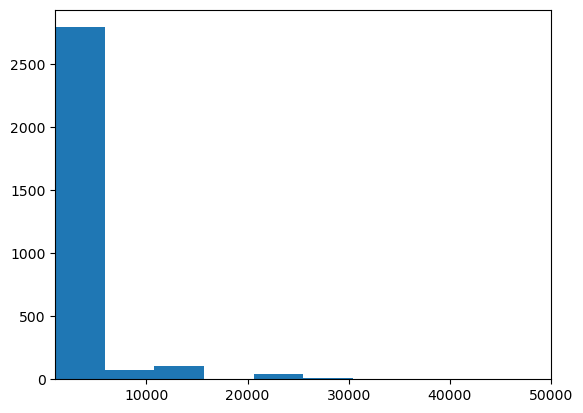

In [13]:
c3d_gttf_array = np.array(c3d_gttf_array)
pt = 0.3*2/np.abs(c3d_gttf_array)

index = np.where(pt>=1000)

plt.hist(pt,range = (1000,50000))
plt.xlim(1000,50000)

In [14]:
chi2_false =[]
chi2_truth = []
for i in range(len(label)):
    if(label[i]):
        chi2_truth.append(chi2_gttf_array[i])
    else:
        chi2_false.append(chi2_gttf_array[i])

    

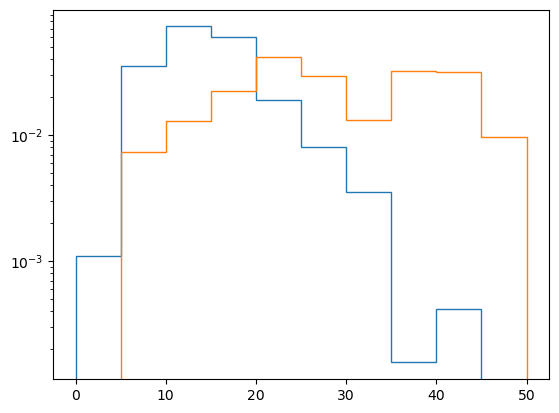

In [15]:
plt.hist(chi2_truth,bins=10,range = (0,50),density = True,histtype='step')
plt.hist(chi2_false,bins=10,range = (0,50),density = True,histtype='step')
plt.yscale('log')
plt.show()


In [16]:
# chi2_gttf_array = chi2_gttf_array[index]
ca_track1 = []
chi2_filter1 = []
for i in index[0]:
    
    ca_track1.append(ca.track_collection[i])
    chi2_filter1.append(chi2_gttf_array[i])
    # if(chi2_gttf_array[i]<=45):
    #     ca_track.append(ca.track_collection[i])
    #     chi2_filter.append(chi2_gttf_array[i])


In [17]:
chi2_filter = np.array(chi2_filter1)
print(len(chi2_filter1))

np.where(np.array(chi2_filter1)<45)[0].shape

3023


(2660,)

In [18]:
ca_track

NameError: name 'ca_track' is not defined

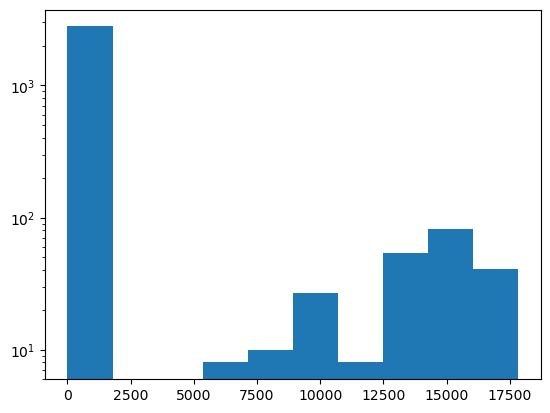

In [19]:
plt.hist(chi2_filter)
plt.yscale('log')
plt.show()

In [20]:
ca_track = []
chi2_filter = []
for i in range(len(chi2_filter1)):
    if(chi2_filter1[i]<=45):
        ca_track.append(ca_track1[i])
        chi2_filter.append(chi2_filter1[i])


In [22]:
eff,pur,per_eff,track_collection_hits = track_reco_meric(ca_track,
                 triplet_arr_chi2,
                 triplet_df_chi2,
                 hits_df,
                 signal_df)


In [23]:
filtered_triplet_arr = triplet_arr_chi2
filtered_triplet_df = triplet_df_chi2
print(eff,pur,per_eff,len(ca_track))

0.9619771863117871 0.09511278195488722 0.9619771863117871 2660


In [24]:
chi2_filter = np.array(chi2_filter)

In [25]:
track_after_first_trimming,chi2_global_after_first_trimming =  disconnecting_the_graph(ca_track,
                                                                                            chi2_filter,
                                                                                            -1)
eff,pur,perfect_eff,total_tracks = track_reco_meric(track_after_first_trimming,filtered_triplet_arr,
                                                        filtered_triplet_df,hits_df,signal_df)

print(eff,pur,perfect_eff)

0.9619771863117871 0.3624641833810888 0.9581749049429658


In [26]:
track_after_second_trimming,chi2_global_after_second_trimming =  disconnecting_the_graph(track_after_first_trimming,
                                                                                        chi2_global_after_first_trimming,
                                                                                        0)
eff,pur,perfect_eff,total_tracks = track_reco_meric(track_after_second_trimming,filtered_triplet_arr,
                                                filtered_triplet_df,hits_df,signal_df)
print(eff,pur,perfect_eff)

0.9619771863117871 0.7620481927710844 0.9543726235741445


In [27]:
final_track_hit,final_chi2_hit = track_sharing_hits(total_tracks,np.array(chi2_global_after_second_trimming))


In [44]:

eff,pur,per_eff = track_metric_hit_level(final_track_hit,hits_df,signal_df)

In [45]:
print(eff,pur,per_eff)

0.717948717948718 0.7613293051359517 0.7150997150997151


In [209]:
len(final_track_hit)

325

In [210]:
np.where(final_chi2_hit<45)[0].shape

(325,)

In [211]:


# Iterate through each pair of lists
for i in range(len(final_track_hit)):
    for j in range(i + 1, len(final_track_hit)):
        # Convert lists to sets for efficient comparison
        set1 = set(final_track_hit[i])
        set2 = set(final_track_hit[j])
        
        # Find common elements
        common_elements = set1.intersection(set2)
        
        # If common elements exist, print the pair of lists and their common elements
        if common_elements:
            print(f"List {i} and List {j} have common elements: {common_elements}")


In [47]:
np.min(pt),np.max(pt),np.mean(pt),np.median(pt)

(618.2265103877878, 27692.165560335234, 2037.3328705375043, 1174.436689886141)

In [32]:
##label final track fit tracks
chi2_truth = []
signal_pids = signal_df.particle_id.unique()
pids = []
chi2_false = []
for i in tqdm(range(len(track_after_second_trimming))):
    track = track_after_second_trimming[i]

    hits = []
    for iter,element in enumerate(np.array(track)):
        iter  = 7-iter
        index_layer = np.where(filtered_triplet_df == iter)[0]

        triplet_element = filtered_triplet_arr[index_layer][int(element)]

 
        hits.extend(triplet_element.hitids)

    hits = np.unique(hits) 

    pid_ = hits_df[hits_df.hit_id.isin(hits)]['particle_id'].values
    # print(pid_)
     ##finsding particle id for all hits in a track
    unique, counts = np.unique(pid_, return_counts=True)
    
    if(np.max(counts)==10):  ##criterion for 100% matching 
        
        if pid_[0] in signal_pids:
            chi2_truth.append(chi2_global_after_second_trimming[i])
            pids.append(pid_[0])  # cji2
        else:
            chi2_false.append(chi2_global_after_second_trimming[i])    
        # cji2

    else:
        chi2_false.append(chi2_global_after_second_trimming[i])


100%|██████████| 332/332 [00:00<00:00, 335.04it/s]


In [34]:
len(pids),len(chi2_truth),len(chi2_false),len(signal_pids)

(251, 251, 81, 263)

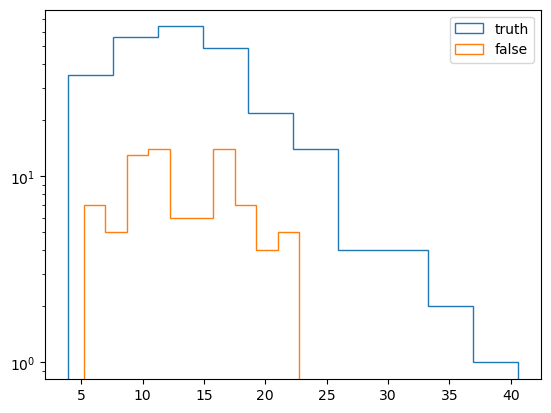

In [35]:
plt.hist(chi2_truth,bins=10,histtype='step',label='truth')
plt.hist(chi2_false,bins=10,histtype='step',label='false')
plt.legend()
plt.yscale('log')
plt.show()


In [83]:
barrel_data = {'barrel_layers': [(8, 2), (8, 4), (8, 6), (8, 8), (13, 2), (13, 4), (13, 6), (13, 8), (17, 2), (17, 4)]} 
hits_df = add_barrel_numbers(hits_df,barrel_data)
(hits_df.barrel_layers.unique())

10

In [ ]:
for pid in 

(array([  0.,   0.,   0.,   0.,   0., 548.,   0.,   0.,   0.,   0.]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5]),
 <BarContainer object of 10 artists>)

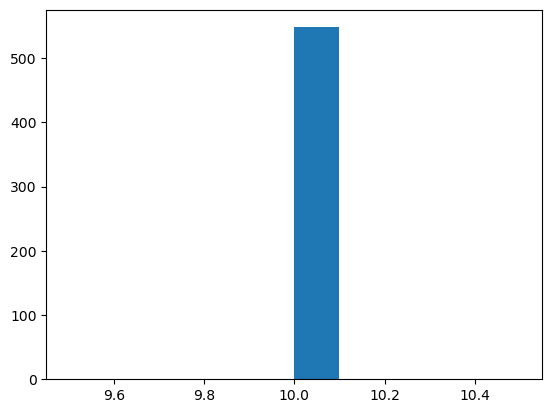

In [96]:
n = []
for pid in pids:

    df = hits_df[hits_df.particle_id==pid]

    n.append(len(df.barrel_layers.unique()))
plt.hist(n)    

In [43]:
def get_signal1(event_df,particles_df,config): ##in gev : #return where hits belong to particles that have momentum 1 GeV
    
    barrel_data = {'barrel_layers': [(8, 2), (8, 4), (8, 6), (8, 8), (13, 2), (13, 4), (13, 6), (13, 8), (17, 2), (17, 4)]} 
    values_to_check = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
    
    rcut_df = particles_df[(particles_df.vx**2+particles_df.vy**2)**0.5<=config['r_cut']]
    zcut_df = rcut_df[abs(rcut_df.vz)<=config['z0_cut']]
    highpt_pids =  zcut_df[(zcut_df.pt>=config['pt_cut']) ]["particle_id"]

    ##now we have pids that corresponds to particle having pt>=pt and deposit nhits or more
    barrel_df  = load_barrel_df(event_df)
    barrel_df = barrel_df[barrel_df.particle_id.isin(highpt_pids)]

    barrel_hdf = add_barrel_numbers(barrel_df,barrel_data)
    unique_pids = np.unique(barrel_hdf['particle_id'].values)
    unique_pids = unique_pids[unique_pids!=0]
    filtered_pids = []
    for pid in unique_pids:
        df = barrel_hdf[barrel_hdf['particle_id']==pid]
        if len(df['barrel_layers'].unique())>=9:
            filtered_pids.append(pid)

    
    signal_df = barrel_hdf[barrel_hdf['particle_id'].isin(filtered_pids)]
    return signal_df

signal_df = get_signal1(hdf,pdf,config)


In [36]:
barrel_data = {'barrel_layers': [(8, 2), (8, 4), (8, 6), (8, 8), (13, 2), (13, 4), (13, 6), (13, 8), (17, 2), (17, 4)]} 
values_to_check = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

rcut_df = pdf[(pdf.vx**2+pdf.vy**2)**0.5<=config['r_cut']]
zcut_df = rcut_df[abs(rcut_df.vz)<=config['z0_cut']]
highpt_pids =  zcut_df[(zcut_df.pt>=0.6) ]["particle_id"]

##now we have pids that corresponds to particle having pt>=pt and deposit nhits or more
barrel_df  = load_barrel_df(hdf)

# print((barrel_df.volume_id.unique()))
barrel_df = barrel_df[barrel_df.particle_id.isin(highpt_pids)]
print(len(barrel_df.particle_id.unique()))


barrel_hdf = add_barrel_numbers(barrel_df,barrel_data)


unique_pids = np.unique(barrel_hdf['particle_id'].values)
print(len(unique_pids))



filtered_pids = []

print(config['nhits'])
nn = []
for pid in unique_pids:
    df = barrel_hdf[barrel_hdf['particle_id']==pid]
    nn.append(len(df['barrel_layers'].unique()))
    # print(df)
    # assert False
    if (len(df['barrel_layers'].unique())==config['nhits']):
        filtered_pids.append(pid)

print(len(filtered_pids),"dkijhgdigfiydgiuygdf")
signal_df = barrel_hdf[barrel_hdf['particle_id'].isin(filtered_pids)]
print(len(signal_df.particle_id.unique()))



2438
2438
10
607 dkijhgdigfiydgiuygdf
607


In [37]:
c = 0
falt_pids =  []
for pid in pids:
    if pid not in unique_pids:
        falt_pids.append(pid)
  

In [38]:
falt_pids

[]

<Axes: >

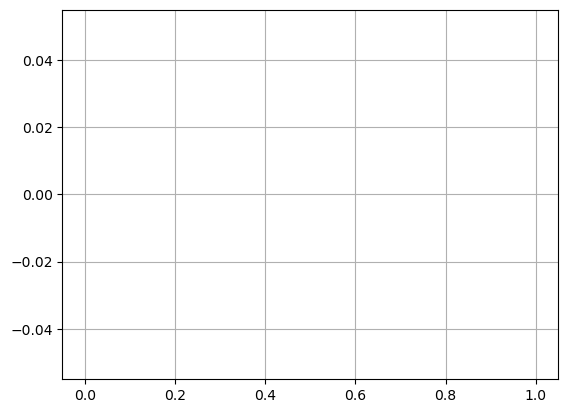

In [39]:
fpdf = pdf[pdf.particle_id.isin(falt_pids)]
fpdf.pt.hist(bins=100)  

In [40]:
nn = np.array(nn)
len(np.where(nn==10)[0])

607

(array([292., 355.,  64., 245.,  86., 219., 199., 163., 208., 607.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

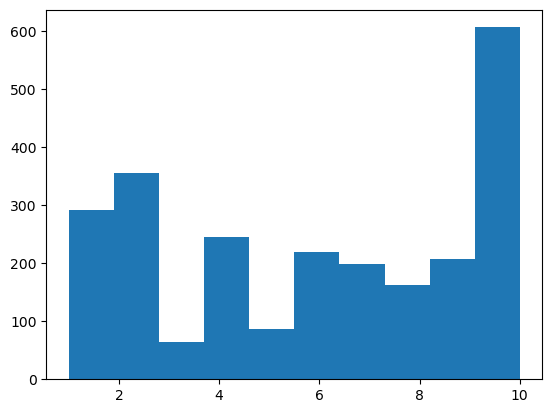

In [41]:
plt.hist(nn)

In [42]:
hits_df[hits_df.particle_id==4503805785800704]

Empty DataFrame
Columns: [hit_id, particle_id, tx, ty, tz, tpx, tpy, tpz, weight, x, y, z, volume_id, layer_id, module_id, module_index, region, cell_count, cell_val, leta, lphi, lx, ly, lz, geta, gphi, r, phi]
Index: []

In [4]:
fname1 = f'generated_tracks/triplet_level/inside_out/event_{eno}.pkl'
with open(fname1,'rb') as f:
    track_class  = pickle.load(f)


In [26]:
def track_assign(track_collection,triplet_arr,triplet_df,hits_df,signal_df):
    label = []

    for track in track_collection:  ##looping pover final tracks
        hits = []  ##this will store hit ids for all hits within a single track
        for iter,element in enumerate(track):
            iter  = 7-iter
            index_layer = np.where(triplet_df == iter)[0]

            triplet_element = triplet_arr[index_layer][element]
            hits.extend(triplet_element.hitids)

        hits = np.unique(hits)  ##finsiding unique hits..beacuse a hit can be shared by multiple triplets

        pid_ = hits_df[hits_df.hit_id.isin(hits)]['particle_id'].values  ##finsding particle id for all hits in a track
        unique, counts = np.unique(pid_, return_counts=True)
    
        if(np.max(counts)==10):  ##criterion for 100% matching 
            
            label.append(True)       
        else:
            label.append(False)    
    return label        

In [27]:
final_track  = track_class.final_track_triplet
len(final_track)

587

In [28]:
label = track_assign(final_track,triplet_arr,triplet_df,hits_df,signal_df)

In [29]:
for i in range(len(label)):
    if(label[i]==True):
        break;

In [9]:
label[i],i

(True, 134)

In [10]:
track_candidate  = final_track[i]
track_candidate = list(track_candidate)
track_candidate

[3462, 4415, 1914, 2166, 2523, 2156, 1923, 3261]

In [11]:
chi_square = track_class.final_chi2_triplet[i]
chi_square

101.78628188368384

In [12]:
te = triplet_arr[0]


In [13]:
##get_triplet chi2 
for iter,element in enumerate(track_candidate):
    iter  = 7-iter
    index_layer = np.where(triplet_df == iter)[0]

    triplet_element = triplet_arr[index_layer][element]
    print(triplet_element.chi2min_gen)

6.163187502096159
4.481512464443555
5.014239544755757
1.7725009093122708
61.65246236033948
911.6021164514802
78.11728401335209
742.1839634713637


In [19]:
##refit them
triplet_list = []
for iter,element in enumerate(track_candidate):
    iter  = 7-iter
    index_layer = np.where(triplet_df == iter)[0]

    triplet_element = triplet_arr[index_layer][element]



    main_triplet_fit(triplet_element,hits_df,config)
    print(triplet_element.chi2min_gen)
    triplet_list.append(triplet_element)

6.163187502096159
4.481512464443555
5.014239544755757
1.7725009093122708
61.65246236033948
911.6021164514802
78.11728401335209
742.1839634713637


In [20]:
a = [1,2,3]
a.reverse()
a

[3, 2, 1]

In [21]:
# triplet_list.reverse()

In [22]:
gtf = GTTF(triplet_list)

In [23]:
gtf.chi2_glob

18156.951654676555

In [8]:
for eno in tqdm([2,4]):
    
    hdf,pdf = read_files(eno)
    hits_df = load_barrel_df(hdf)
    signal_df = get_signal(hdf,pdf,config)

    triplet_arr_fname,triplet_df_fname,ca_fname = fname(config['sigma_cut_doublets'],eno)


    with open(triplet_arr_fname,'rb') as f:
        triplet_arr = pickle.load(f)
    with open(triplet_df_fname,'rb') as f:
        triplet_df = pickle.load(f)
    with open(ca_fname,'rb') as f:
        ca_class = pickle.load(f)    

    # filtered_triplet_arr,filtered_triplet_df = triplet_array_after_chi2_cut(triplet_arr,triplet_df,config)    


    chi2_truth_triplet= [] ## array for storing track quality of each track
    chi2_false_triplet = []

    for trip in tqdm(triplet_arr):
        main_triplet_fit(trip,hits_df,config)
        if(trip.label==True):
            chi2_truth_triplet.append(trip.chi2min_gen)
        else:
            chi2_false_triplet.append(trip.chi2min_gen)
        
            # assert False


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [25:32<?, ?it/s]


KeyboardInterrupt: 

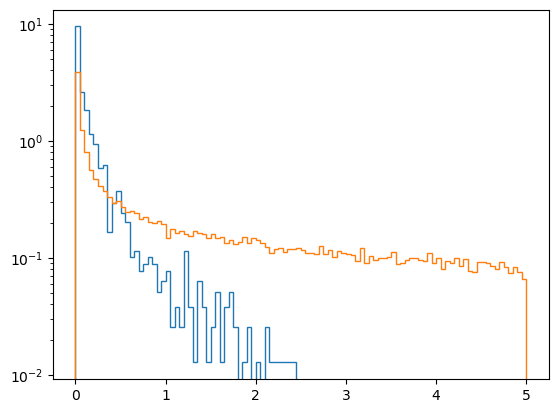

In [14]:
plt.hist(chi2_truth_triplet,bins=100,density = True,histtype='step',range = (0,5))
plt.hist(chi2_false_triplet,bins=100,density = True,histtype='step',range = (0,5))
plt.yscale('log')
plt.show()


In [4]:


chi2_gttf_array= [] ## array for storing track quality of each track

for track in tqdm(ca_class.track_collection):
    hits = []
    triplet_object_array = []
    for iter,element in enumerate(track):
        iter  = 7-iter
        index_layer = np.where(filtered_triplet_df == iter)[0]

        triplet_element = filtered_triplet_arr[index_layer][element]

        triplet_object_array.append(triplet_element)


        hits.extend(triplet_element.hitids)

    hits = np.unique(hits)  ##finsiding unique hits..beacuse a hit can be shared by multiple triplets

    pid_ = hits_df[hits_df.hit_id.isin(hits)]['particle_id'].values  ##finsding particle id for all hits in a track
    unique, counts = np.unique(pid_, return_counts=True)

    if(np.max(counts)==10):  ##criterion for 100% matching 
        new_list = []
        for trip in triplet_object_array:
            main_triplet_fit(trip,hits_df,config)
            new_list.append(trip)
        new_list.reverse()
        gttf_class = GTTF(new_list)
        # print(gttf_class.chi2_glob)
        # print(triplet_object_array)
        chi2_gttf_array.append(gttf_class.chi2_glob)
    
        # assert False

100%|██████████| 3854/3854 [05:38<00:00, 11.38it/s]


In [6]:
trip.label

False

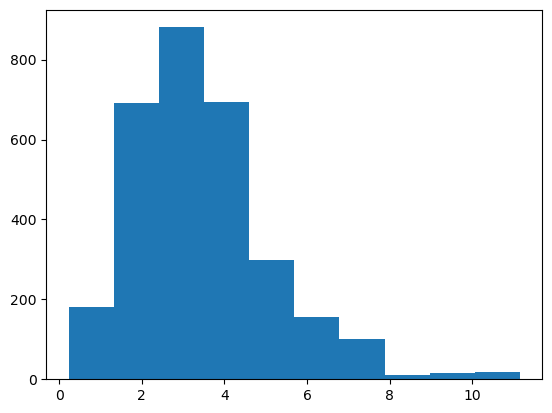

In [5]:
plt.hist(chi2_gttf_array)
plt.show()

In [6]:
triplet_object_array
new_triplet = []

for trip in triplet_object_array:
    print("before",trip.chi2min_gen)
    main_triplet_fit(trip,hits_df,config)
    print("after",trip.chi2min_gen)
    new_triplet.append(trip)
    print("end=====================")



before 0.4154037890381984
after 0.4122802879931268
end=====================
before 0.7482815544599087
after 0.7382128900893354
end=====================
before 0.24972911123166158
after 0.2212584909980384
end=====================
before 0.7538183748132009
after 0.6932413479061263
end=====================
before 0.4938050679436558
after 0.4595046694651298
end=====================
before 2.8735095092357708
after 2.8735095092357708
end=====================
before 0.040477392464578786
after 0.040477392464578786
end=====================
before 0.011888300681387902
after 0.011888300681387902
end=====================


In [7]:
new_triplet.reverse()
gtf_class = GTTF(new_triplet)
gtf_class.chi2_glob

9.88350748214907